# Chapter 3: Classification 

## MNIST

For this classification task, I will use the MNIST dataset which consists of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image represents a digit and has been analyzed numerous times and is often the 'Hello World' of machine learning. This dataset, MNIST, is used to see how well a new classifciation algorithm will do. 

### Load Libraries

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.base import clone

### Load the Dataset

After downloading the dataset from Scikit-Learn, the main dictionary keys can be seen as follows: __data__, __target__, __feature_names__, __DESCR__, __details__, __categories__, and __url__. In the next code block thereafter, I will create the input data and the target column denoted as __X__ and __y__.

In [2]:
mnist = fetch_openml('mnist_784', version = 1)
print(mnist.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])


When analyzing the shapes of the two arrays as well, it is seen that there are 70000 images with 784 features. Each image is 28 x 28 pixels and each feature represents one pixel's intensity from 0 to 255. I will reshape the array to a 28 x 28 in order for us to work with it. 

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


From the image below, it is seen that this is indeed the number 5. We reshaped it due to the fact that we were interested in one specific image with 28 x 28 pixels. ALso, in the line below that, since ML algorithms work with numeric data and not string data, I converted the string to an integer. 

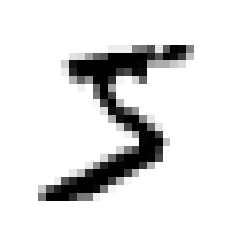

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [5]:
print(y[0])
y = y.astype(np.uint8)

5


Before conducting any further analysis, I will create a train and test set. However, for the MNIST dataset, there are 60,000 data instances and 10,000 target values that were split already. Also, the data is already shuffled and therefore will ensure that the cross-validation folds are similar. It is a good idea to shuffle the dataset because if too many similar instances are seen in a row, the ML algorithm will not perform well sometimes because it may be sensitive to the order of the instances. 

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

I will simplify this particular problem by identifying one digit, for example, 5. This is going to be a binary classifier problem because the two classes I will be predicting are 5 and not 5. I will create the target vectors for the classification tasks. I will also choose a __Stochastic Gradient Descent Classifier__ using scikit-learn's SGDClassifier class. 

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Below this cell, I used the __Stochastic Gradient Descent Classifier__ fitted to the train and y_train_5 data and predicted that the value 5 which yielded true. I will now evaluate the model's performance measure. 

In [9]:
sgd_clf.predict([some_digit])

array([ True])

### Measuring Accuracy of Stochastic Gradient Descent Classifier Using Cross-Validation

In order to evaluate the model, I will use cross-validation. Usually speaking, might need to modify the cross-validation more than what scikit-learn provides. Therefore, this is a modified way of writing it which is very similar to cross_val_score(). 


In [10]:
skfolds = StratifiedKFold(random_state = 42, n_splits = 3)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [11]:
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [12]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [13]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [14]:
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311
0.7325171197343846


In [15]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

For the next two examples, I will show that when __raising the threshold, recall will decrease__. The image that is actually classified is a 5 for the threshold of 8000, but misses it because of the fact that the threshold value is 8000. If trying to decide what threshold to use, for the cross_val_predict function, set method to decision_function instead of returning the predictions. 

In [16]:
threshold = 0 
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [17]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

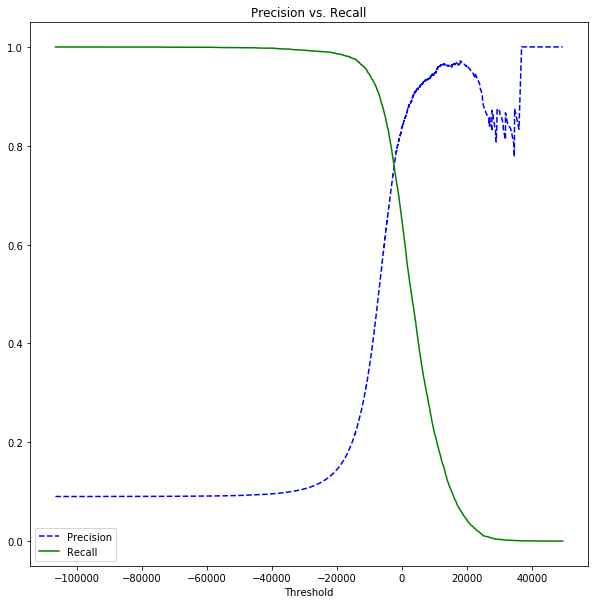

In [19]:
def plot_precision_recall_curve(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize = (10,10))
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.legend()
    ax.set_title('Precision vs. Recall')
    ax.set_xlabel('Threshold')
    
plot_precision_recall_curve(precisions, recalls, thresholds)
plt.show()

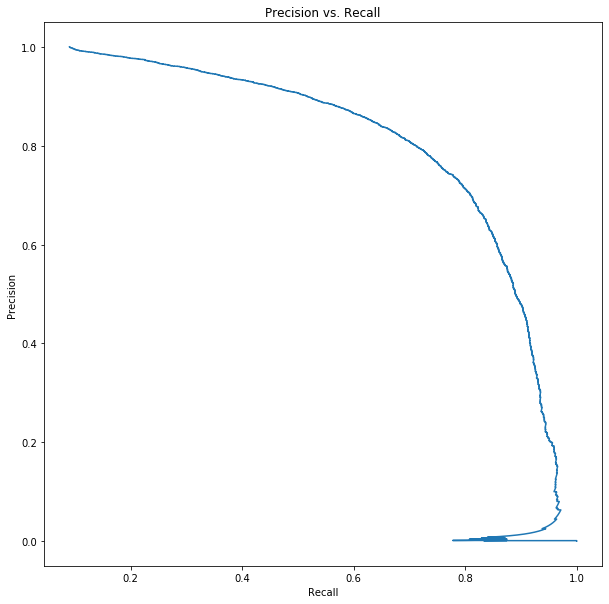

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Precision vs. Recall')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.plot(precisions, recalls)
plt.show()

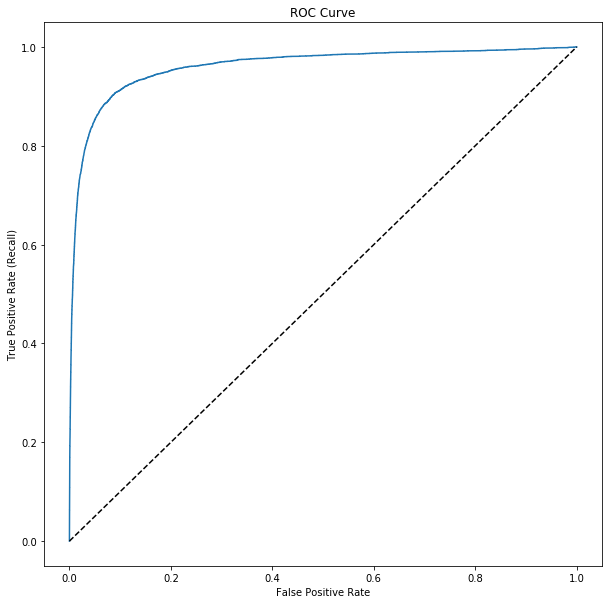

In [21]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label = None):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(fpr, tpr, label = label)
    plt.plot([0,1], [0,1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel("True Positive Rate (Recall)")
    ax.set_title('ROC Curve')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [22]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Random Forest Classifier vs. Stochastic Gradient Descent Classifier ROC Curve

In [23]:
rf_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(rf_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


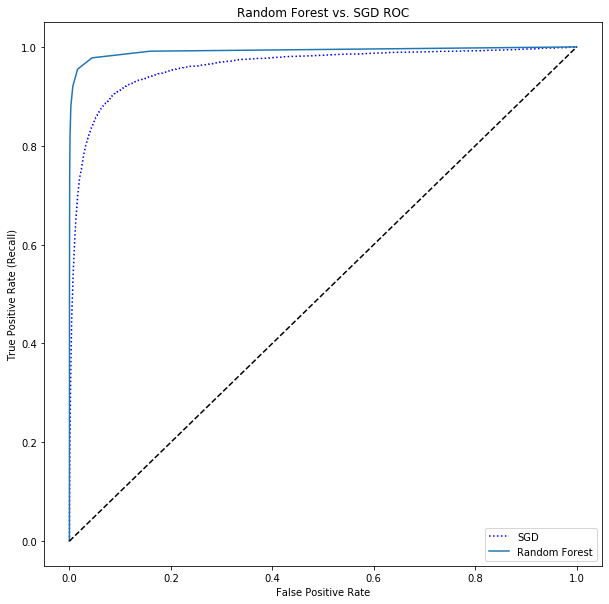

In [24]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
fig, ax = plt.subplots(figsize = (10,10))
ax.set_title('Random Forest vs. SGD ROC')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate (Recall)')
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plt.plot(fpr_forest, tpr_forest, label = 'Random Forest')
plt.plot([0,1], [0,1], 'k--')
plt.legend(loc = 'lower right')
plt.show()

In [25]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

## Multiclass Classification

Previously, I looked at binary classification in which I was trying to predict whether a certain instance belonged to a certain class. For example, in the previous case, I compared whether I could classify an image as a 5 or not a 5. Besides binary classification though, there is also something called multiclass classification in which the goal is to predict multiple classes. There are two methods to do this, __one vs. all__ and __one vs. one__. In __one vs. all__, for example, let's say there are digits 0-9. 0 will be trained against all other digits, 1 will be trained against all other digits, all the way up to 9. Then, the class with the highest score is chosen. In __one vs. one__, you train a classifier of 0 vs. 1, 0 vs. 2 and etc. This takes a while, however, some algorithms like the Support Vector Classifier prefers this. However, most other binary classification algorithms prefer the one vs. all. Also, this can be extended to __Multilabel Classification__ and __MultiOutput Classification__. 

In [27]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)